# Log-Realized Volatility Forecasting with HAR (Walk-Forward Evaluation)

This notebook implements a rolling out-of-sample forecasting framework for daily
realized volatility. The modeling approach follows the realized volatility
framework of Andersen, Bollerslev, Diebold, and Labys (2003), who show that realized
volatility constructed from high-frequency returns can be treated as an observable
process whose logarithm is approximately Gaussian and highly persistent.

Based on these results, realized volatility is modeled directly in log space.
Forecast dynamics are captured using the Heterogeneous Autoregressive (HAR)
specification of Corsi (2009), estimated on a rolling window and evaluated via
walk-forward multi-horizon forecasts using the QLIKE loss function.

The objective is to produce a well-calibrated realized volatility forecast suitable
as a fair-value anchor for implied volatility analysis.


# RV serie construction

In this Notebook we used Bitcoin to forecast the realized volatility. We relied on the historical data from Binance. Using the work of Andersen and al. we modeled the realized volatility on a day $t$ as: 
$$ RV_t = \sum_{j=1}^N r_{t,j}^2, $$


where $r_{t,j}$ are intraday log returns: $r_{t,j} = \log(P_{t,j}) - \log(P_{t,j-1})$. $P_{t,j}$ is the price at intraday timestamp $j$ on day $t$ and $N$ is the number of intraday timestamps. In this notebook $N=288$ since the timestamp is 5min. 

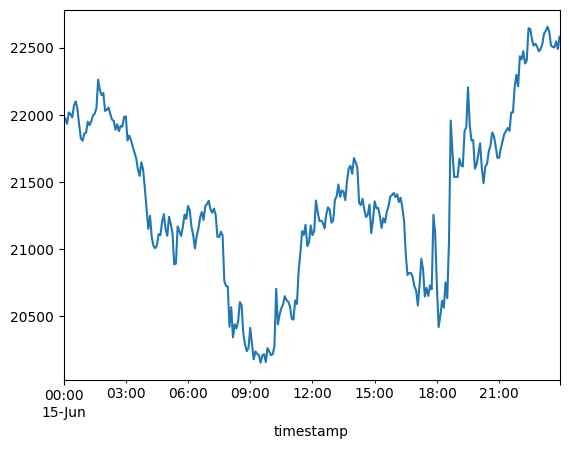

In [ ]:
import time
import ccxt
import pandas as pd
import numpy as np

exchange = ccxt.binance({'enableRateLimit': True})

def fetch_5m_history(symbol, start_date, end_date):
    timeframe = '5m'
    since = exchange.parse8601(start_date)
    end_ts = exchange.parse8601(end_date)

    all_ohlcv = []

    while since < end_ts:
        ohlcv = exchange.fetch_ohlcv(
            symbol,
            timeframe,
            since=since,
            limit=1000
        )
        if not ohlcv:
            break

        all_ohlcv.extend(ohlcv)
        since = ohlcv[-1][0] + 1
        time.sleep(exchange.rateLimit / 1000)

    return all_ohlcv

ohlcv = fetch_5m_history(
    symbol='BTC/USDT',
    start_date='2021-01-01T00:00:00Z',
    end_date='2024-01-01T00:00:00Z'
)

df = pd.DataFrame(
    ohlcv,
    columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
)

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
df = df.sort_values('timestamp').set_index('timestamp')


df['date'] = df.index.date
df['intraday_id'] = (
    (df.index.hour * 60 + df.index.minute) // 5
)

daily_intraday = {
    day: day_df
    for day, day_df in df.groupby('date')
}

#test on one day
day_df = daily_intraday[pd.to_datetime('2022-06-15').date()]
day_df['close'].plot(title = '15 june intraday BTC spot evolution', ylabel = 'BTC spot')


#Cleaning data to only keep trading days with the expected 288 intraday timestamps
EXPECTED_BARS = 288

daily_intraday_full = {
    day: day_df
    for day, day_df in daily_intraday.items()
    if len(day_df) >= EXPECTED_BARS
}

RV = {}

for day, day_df in daily_intraday_full.items():
    log_ret = np.log(day_df['close']).diff()
    RV[day] = np.nansum(log_ret**2)

RV = pd.Series(RV).sort_index()

<Axes: >

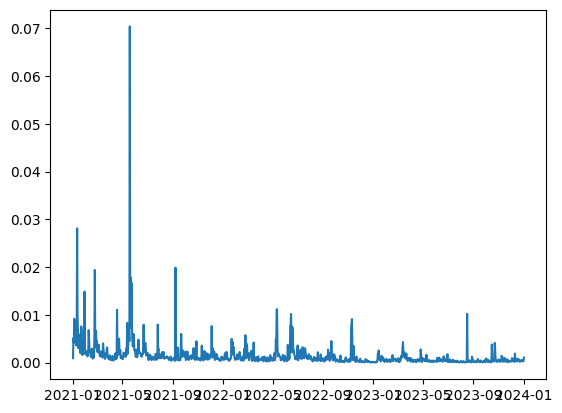

In [100]:
RV.plot()

In [ ]:
#%% Test to see the days without 288 intraday values

full_range = pd.date_range(
    RV.index.min(),
    RV.index.max(),
    freq='D'
).date

missing_days = set(full_range) - set(RV.index)
sorted(missing_days)

[datetime.date(2021, 2, 11),
 datetime.date(2021, 3, 6),
 datetime.date(2021, 4, 20),
 datetime.date(2021, 4, 25),
 datetime.date(2021, 8, 13),
 datetime.date(2021, 9, 29),
 datetime.date(2023, 3, 24)]

## Model construction and forcast

In Andersen and al. it is also said that the logarithms of the realized volatility could be modeled as a persistent long-memory process. Using the work of Corsi (2009) I decided to use the HAR-RV model: 
$$ \log(RV_t) = \beta_0 + \beta_d\log(RV_{t-1}) + \beta_w\log(RV_{t-1:t-7}) + \beta_m\log(RV_{t-1:t-30})  + \epsilon_t, $$

with $$ RV_{t-1:t-7} = \frac{1}{7}\sum_{k=1}^7RV_{t-k}, \quad RV_{t-1:t-30} = \frac{1}{30}\sum_{k=1}^{30}RV_{t-k}.$$

By recursively computing the values of the logarithm using forecasted values when needed we can get the mean of the Realized Volatility h-days in the future as: 

$$ \mathbb{E}[RV_{t+h}] = \exp(\mu_{t+h} + \frac{1}{2}\sigma_h^2), $$

with $\mu_{t+h} = \log(RV_{t+h})$, $\sigma_h^2 = h\times\sigma_{\epsilon}^2$ and $\sigma_{\epsilon}^2 = Var(\epsilon_t)$. The second member in the exponential is the term of bias correction when converting from log-space. 

This forecast uses a OLS on the available data to compute the betas parameters of the model, there is two options for the model used, either an expanding one, the parameters are computed on all the data available to this day, or one with a sampling window, we get the parameters from recent data only.

Once the parameters are computed we iterate the RV prediction for as many days as we want to get our forecasted realized volatility. 

In [92]:
def HAR_RV(t_date, window_days):
    """
    Implementation of the HAR-RV model on log(RV_t) with a rolling window to try to capture recent market moves

    Parameters
    ----------
    t_date : panda.Timestamp
        last day of data available to us, format YYYY-MM-DD
    window_days : int
        number of days used to get the parameters of the model, None for the expanding model

    Returns
    -------
    beta_hat : numpy.ndarray 
        beta parameters of the model
    sigma_eps2 : float
        squared var of the residual 
    """

    if window_days == None:
        RV_used = RV.loc[:t_date]
    else:
        start_date = t_date - pd.Timedelta(days=window_days)

        if start_date < RV.index[0]:
            RV_used = RV.loc[:t_date] # Fall back to all available data if window exceeds history
        else:
            RV_used = RV.loc[start_date:t_date]
    
    RV_d = RV_used.shift(1)
    RV_W = RV_used.rolling(window = 7).mean().shift(1)
    RV_M = RV_used.rolling(window = 30).mean().shift(1)

    X_d = np.log(RV_d)
    X_w = np.log(RV_W)
    X_m = np.log(RV_M)
    Y = np.log(RV)

    data = pd.concat(
        [Y, X_d, X_w, X_m],
        axis=1
    )

    data.columns = ['Y', 'X_d', 'X_w', 'X_m']
    data = data.dropna()

    Y_mat = data['Y'].values

    X_mat = np.column_stack([
        np.ones(len(data)),
        data['X_d'].values,
        data['X_w'].values,
        data['X_m'].values
    ])

    beta_hat, _, _, _ = np.linalg.lstsq(X_mat, Y_mat, rcond=None)

    Y_hat = X_mat @ beta_hat
    resid = Y_mat - Y_hat

    sigma_eps2 = resid.var(ddof=X_mat.shape[1])

    return beta_hat, sigma_eps2 

def RealVar_forecast(t_date, T, window_days):
    """
    Forecast RV for next T days using recursive HAR-RV with the rolling window

    Parameters
    ----------
    t_date : panda.Timestamp
        last day of data available to us, format YYYY-MM-DD
    T : int
        in how many days we want the predicted volatility
    window_days : int
        number of days used to get the parameters of the model, None for the expanding HAR-RV model

    Returns
    -------
    RV_forecast : list
        list of the daily forecast
    np.sum(RV_forecast): float
        cumulative forecast
    """

    RV_history = RV.loc[:t_date]    # Get historical RV up to t_date
    beta_hat, sigma_eps2 = HAR_RV(t_date, window_days)
    beta0, beta_d, beta_w, beta_m = beta_hat
    logRV_hist = list(np.log(RV_history.iloc[-30:]))
    
    # Forecast for each horizon
    RV_forecast = []
    for h in range(1, T+1):
        # Current day (most recent) is at index -1
        RV_d = np.exp(logRV_hist[-1])
        
        # Weekly average (last 7 days)
        if len(logRV_hist) >= 7:
            RV_w = np.mean(np.exp(logRV_hist[-7:]))
        else:
            RV_w = np.mean(np.exp(logRV_hist))
            
        # Monthly average (last 30 days)
        if len(logRV_hist) >= 30:
            RV_m = np.mean(np.exp(logRV_hist[-30:]))
        else:
            RV_m = np.mean(np.exp(logRV_hist))
        
        # Forecast log RV for next day
        logRV_next = (
            beta0 
            + beta_d * np.log(RV_d)
            + beta_w * np.log(RV_w)
            + beta_m * np.log(RV_m)
        )
        
        RV_next = np.exp(logRV_next + 0.5 * sigma_eps2)
        
        RV_forecast.append(RV_next)
        logRV_hist.append(np.log(RV_next))
    
    return RV_forecast, np.sum(RV_forecast)

def RealVar_realized(t_date, T):
    """
    Get realized RV for next T days
    
    Parameters
    ----------
    t_date : panda.Timestamp
        last day of data available to us, format YYYY-MM-DD
    T : int
        in how many days we want the predicted volatility

    Returns
    -------
    list of daily realized vol and cumulative vol
    
    """
    # Ensure we get the next T trading days
    future_dates = RV.loc[t_date:].index
    # Skip t_date itself and get next T days
    next_dates = future_dates[future_dates > t_date][:T]
    return RV.loc[next_dates].sum(), RV.loc[next_dates]

# Example 
RV.index = pd.to_datetime(RV.index)
t_date = pd.Timestamp("2022-06-13")
T = 7
window_days = None

daily_forecasts, forecast_cum = RealVar_forecast(t_date, T, window_days)
realized_cum, realized_daily = RealVar_realized(t_date, T)

print(f"Date: {t_date.date()}")
print(f"Forecast period: {T} days")
print(f"HAR-RV rolling window size: {window_days} days")
print(f"Forecast period: {T} days")
print(f"Cumulative forecast: {forecast_cum:.6f}")
print(f"Cumulative realized: {realized_cum:.6f}")
print(f"Ratio: {realized_cum / forecast_cum:.4f}")
print("\nDaily forecasts:", [f"{x:.6f}" for x in daily_forecasts])
print("Daily realized:", [f"{x:.6f}" for x in realized_daily.values])

Date: 2022-06-13
Forecast period: 7 days
HAR-RV rolling window size: None days
Forecast period: 7 days
Cumulative forecast: 0.018456
Cumulative realized: 0.041251
Ratio: 2.2351

Daily forecasts: ['0.003629', '0.002674', '0.002407', '0.002374', '0.002398', '0.002463', '0.002510']
Daily realized: ['0.008029', '0.010161', '0.003328', '0.002102', '0.007484', '0.006814', '0.003334']


In [ ]:
def print_model_summary(t_date):
    """Check estimated coefficients"""
    beta_hat, sigma_eps2 = HAR_RV(t_date)
    
    print("HAR-RV Model Coefficients:")
    print(f"β₀ (constant): {beta_hat[0]:.4f}")
    print(f"β_d (daily): {beta_hat[1]:.4f}")
    print(f"β_w (weekly): {beta_hat[2]:.4f}")
    print(f"β_m (monthly): {beta_hat[3]:.4f}")
    print(f"σ²_ε: {sigma_eps2:.6f}")
    
    persistence = beta_hat[1] + beta_hat[2] + beta_hat[3]
    print(f"Persistence (sum of β's): {persistence:.3f}")
    if persistence > 0.95:
        print("Warning: High persistence may cause upward bias")

print_model_summary(pd.Timestamp("2021-08-13"))

## Walk-Forward Forecasting and Evaluation

To assess out-of-sample forecasting performance, we implement a systematic
walk-forward backtest. At each forecast origin, the HAR model is estimated using
only information available up to that date, and a multi-step forecast of realized
volatility is produced for the next $T$ trading days.

Forecasts are generated at a fixed re-estimation frequency (every $k$ days),
ensuring that parameter estimation and evaluation strictly respect the temporal
ordering of the data. This setup avoids look-ahead bias and mirrors a realistic
forecasting environment.

### Forecast target

The object of interest is the **cumulative realized volatility** over the next
$T$ days:

$$ RV_{t,t+T} = \sum_{h=1}^{T} RV_{t+h} $$

Model forecasts are constructed recursively at the daily level and aggregated
to match this evaluation horizon.

### Evaluation metric

Forecast accuracy is primarily evaluated using the QLIKE loss function:

$$ \text{QLIKE}(RV, \widehat{RV})
= \frac{RV}{\widehat{RV}} - \log\!\left(\frac{RV}{\widehat{RV}}\right) - 1 $$

QLIKE is a proper scoring rule for volatility forecasts and is robust to
measurement error in realized volatility. Additional diagnostics, such as the
ratio of realized to forecast volatility, are also reported to assess bias and
dispersion.

### Outputs

The backtest returns:
- a time series of out-of-sample forecasts and realizations,
- summary statistics of forecast performance,
- and the sequence of estimated model coefficients for diagnostic analysis.

In [ ]:
def walk_forward_backtest(start_date, end_date, T=7, window_days=180, 
                          retrain_every=7, metric='QLIKE'):
    """
    Systematic walk-forward backtest
    
    Parameters:
    - start_date: First forecast date
    - end_date: Last forecast date  
    - T: Forecast horizon (days)
    - window_days: Estimation window
    - retrain_every: How often to re-estimate model (days)
    - metric: Evaluation metric ('QLIKE', 'MSE', 'MAE', 'MAPE')
    """
    
    # Generate forecast dates
    forecast_dates = pd.date_range(start=start_date, end=end_date, freq=f'{retrain_every}D')
    
    results = {
        'dates': [],
        'forecasts': [],
        'actuals': [],
        'errors': [],
        'cumulative_forecast': [],
        'cumulative_actual': [],
        'ratios': [],
        'model_coefs': []
    }
    
    for i, forecast_date in enumerate(forecast_dates):
        if forecast_date not in RV.index or forecast_date + pd.Timedelta(days=T) not in RV.index:
            continue
            
        try:
            daily_forecasts, forecast_cum = RealVar_forecast(forecast_date, T, window_days)
            realized_cum, realized_daily = RealVar_realized(forecast_date, T)
            
            # Calculate error based on metric
            if metric == 'QLIKE':
                error = realized_cum/forecast_cum - np.log(realized_cum/forecast_cum) - 1
            elif metric == 'MSE':
                error = (forecast_cum - realized_cum) ** 2
            elif metric == 'MAE':
                error = abs(forecast_cum - realized_cum)
            elif metric == 'MAPE':
                error = abs(forecast_cum - realized_cum) / realized_cum * 100
            
            results['dates'].append(forecast_date)
            results['forecasts'].append(forecast_cum)
            results['actuals'].append(realized_cum)
            results['errors'].append(error)
            results['cumulative_forecast'].append(forecast_cum)
            results['cumulative_actual'].append(realized_cum)
            results['ratios'].append(realized_cum / forecast_cum)
            
            beta_hat, _ = HAR_RV_rolling(forecast_date, window_days)
            results['model_coefs'].append(beta_hat)
            
        except Exception as e:
            print(f"Error at {forecast_date}: {e}")
            continue
    
    results_df = pd.DataFrame({
        'date': results['dates'],
        'forecast': results['forecasts'],
        'actual': results['actuals'],
        'error': results['errors'],
        'ratio': results['ratios']
    })
    
    summary = {
        'n_forecasts': len(results_df),
        'mean_error': results_df['error'].mean(),
        'std_error': results_df['error'].std(),
        'mean_ratio': results_df['ratio'].mean(),
        'ratio_std': results_df['ratio'].std(),
        'bias': (results_df['forecast'] - results_df['actual']).mean(),
        'hit_rate': (results_df['ratio'] > 0.8).mean()
    }
    
    return results_df, summary, results['model_coefs']

start_date = pd.Timestamp("2020-01-01")
end_date = pd.Timestamp("2023-12-31")
T = 7
window_days = 180

results_df, summary, coefs = walk_forward_backtest(
    start_date, end_date, T, window_days, retrain_every=7, metric='QLIKE'
)

print("Backtest Summary:")
print("=" * 80)
for key, value in summary.items():
    print(f"{key:20}: {value:.6f}" if isinstance(value, float) else f"{key:20}: {value}")

C:\Users\victo\AppData\Local\Temp\ipykernel_18992\1649598567.py:58: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma_eps2 = resid.var(ddof=X_mat.shape[1])
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\victo\AppData\Local\Temp\ipykernel_18992\1649598567.py:58: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma_eps2 = resid.var(ddof=X_mat.shape[1])
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packag

Backtest Summary:
n_forecasts         : 153
mean_error          : 0.295830
std_error           : 0.910282
mean_ratio          : 1.000868
ratio_std           : 1.340455
bias                : 0.001186
hit_rate            : 0.372549


## Interpretation of Out-of-Sample Results

The walk-forward evaluation indicates that the rolling log-HAR model is broadly well calibrated in levels. The mean realized-to-forecast ratio is close to one, and the average forecast bias is small, suggesting no systematic over- or under-forecasting over the evaluation period.

At the same time, forecast dispersion is substantial, as reflected in the large
standard deviation of the realized-to-forecast ratio and the variability of the
QLIKE loss. This behavior is consistent with the smooth dynamics imposed by the HAR structure, which capture persistent volatility components but react slowly to abrupt volatility jumps.

Rolling estimation improves adaptability to changing volatility regimes but reduces effective sample sizes due to lag construction and rolling averages. This trade-off primarily affects forecast uncertainty rather than average calibration.

Overall, the results are interpreted as diagnostic evidence of forecast behavior rather than as indications of exploitable predictability. The model is intended to serve as a stable realized-volatility benchmark and fair-value anchor for subsequent implied volatility analysis.


In [90]:
def calculate_r2(results_df):
    """Calculate R-squared for your forecasts"""
    # R² = 1 - SSE/SST
    # Where SSE = sum of squared errors, SST = total sum of squares
    
    sse = ((results_df['forecast'] - results_df['actual']) ** 2).sum()
    sst = ((results_df['actual'] - results_df['actual'].mean()) ** 2).sum()
    
    r2 = 1 - (sse / sst) if sst > 0 else np.nan
    
    # Directional accuracy
    direction_correct = (
        (results_df['forecast'].diff() > 0) == (results_df['actual'].diff() > 0)
    ).mean()
    
    return {
        'r2': r2,
        'direction_accuracy': direction_correct,
        'sse': sse,
        'sst': sst
    }

# Calculate for your results
r2_metrics = calculate_r2(results_df)
print(f"R²: {r2_metrics['r2']:.3f}")
print(f"Directional accuracy: {r2_metrics['direction_accuracy']:.2%}")

R²: 0.445
Directional accuracy: 47.06%
